In [1]:
from PIL import Image # get the image
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 16]

In [2]:
"""
Parameters used for OpenCv functions
We can find these by playing with the dashboard
"""
gaussian_w = 5 # width of the gaussian filter
gaussian_h = 5 # height of the gaussian filter
sigmaX = 5 # review what this does
canny_minval = 100 # refers to strength of edges
canny_maxval = 200
canny_aperature = 3 # this is the size of the sobel kernel, review sobel kernels


## 1. Get picture of current board

In [3]:
img_path = "../data/nashirBoard.JPG" # testing with Nashirs board

# # img_path = "../data/move_dataset/game2/empty.jpg"
# img_path = "../data/topdown-board.jpg"

orig_img = np.array(Image.open(img_path)) # need to convert image into a numpy array

scale_percent = 20 # percent of original size
width = int(orig_img.shape[1] * scale_percent / 100)
height = int(orig_img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv.resize(orig_img, dim, interpolation = cv.INTER_AREA)

# img = orig_img

print(img.shape)

(604, 806, 3)


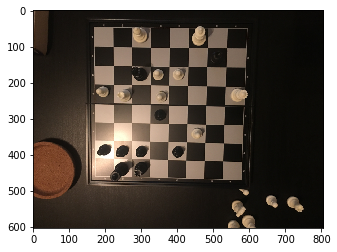

In [4]:
plt.imshow(img)

## 2. Edge detection

In [5]:
gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # convert to gray scale, easier to detect with a gray scale image
blur_img  = cv.GaussianBlur(gray_img,(gaussian_w,gaussian_h),sigmaX) # blurring is important for removing noise

In [6]:
canny_edges = cv.Canny(blur_img,canny_minval,canny_maxval,canny_aperature) #finds the edges of the image using canny

## 3. Line detection

In [7]:
hough_lines = cv.HoughLines(canny_edges,1,np.pi/180,150, None, 0, 0) ## review paramters here for drawing the lines

In [8]:
def draw_lines(img, hough_lines):
    out_img = img.copy()
    # code from opencv to draw lines found from hough transform on an image
    for i in range(0, len(hough_lines)):
        rho = hough_lines[i][0][0]
        theta = hough_lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

        out_img = cv.line(out_img, pt1, pt2, (255,255,255), 2, cv.LINE_AA)
    return out_img

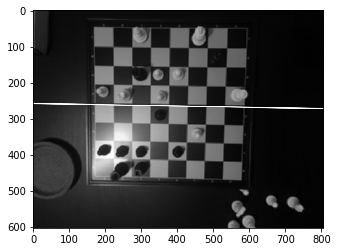

In [9]:
img_w_lines = draw_lines(blur_img, hough_lines)
# show the image
plt.imshow(img_w_lines, cmap='gray')

## 4. Compute line intersection points

## 5. Find corners of the chess board

#### Using Harris Corner Detector

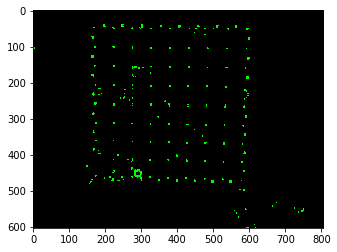

In [10]:
# filename = 'chessboard.png'
# img = cv.imread(filename)
corners_img = img.copy()
gray = cv.cvtColor(corners_img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
corners_img[dst>0.01*dst.max()]=[0,255,0]
corners_img[dst<=0.01*dst.max()]=[0,0,0]
# cv.imshow('dst',img)
# if cv.waitKey(0) & 0xff == 27:
#     cv.destroyAllWindows()
plt.imshow(corners_img)

#### Using find chessboard corners

[This SO post](https://stackoverflow.com/a/63243150) says that a black and white square chessboard is required for using find chessboard corners, so not necessarily valid for us.

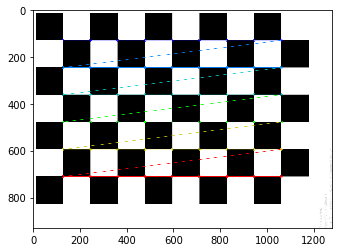

In [11]:
nline = 9
ncol = 6

chessboard_img = cv.imread("../data/generic-chessboard.jpg")

## processing
gray = cv.cvtColor(chessboard_img, cv.COLOR_BGR2GRAY)

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Arrays to store object points and image points from all the images.
imgpoints = [] # 2d points in image plane.

ret = False
# Find the chess board corners
ret, corners = cv.findChessboardCorners(gray, (nline, ncol))
# If found, add object points, image points (after refining them)
if ret == True:
    cv.cornerSubPix(gray, corners, (11, 11), (-1,-1), criteria)
    # Draw and display the corners
    cv.drawChessboardCorners(chessboard_img, (nline, ncol), corners, ret)
    plt.imshow(chessboard_img)
else:
    print("couldn't find corners")

[The above SO post](https://stackoverflow.com/a/63243150) recommends the following workflow:
- Apply bilateral filter to smooth the image
- Find corners using `goodFeaturesToTrack` with appropriate parameters

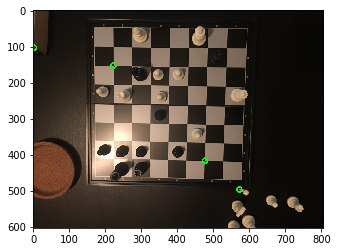

In [12]:
# Reading the images 
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
raw = img.copy()

# Applying a bilateral filter to smooth the image
bilateral_filtered_image = cv.bilateralFilter(gray, 5, 75, 75)

# Find corner points using goodFeaturestoTrack with appropriate parameters
corners_np = cv.goodFeaturesToTrack(bilateral_filtered_image, 4, 0.1, 120)
corners = [list(corner[0]) for corner in corners_np]

for corner in corners:
    cv.circle(raw, (corner[0], corner[1]), 7, (0, 255, 0), 3)
plt.imshow(raw)

#### Using findContours

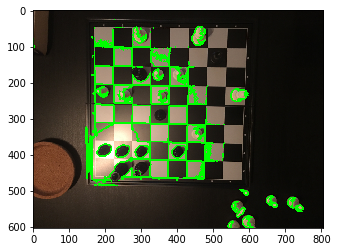

In [13]:
raw = img.copy()
ret, thresh = cv.threshold(gray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

# # draw all
cv.drawContours(raw, contours, -1, (0,255,0), 3)

# draw max

# c = max(contours, key=cv.contourArea)
# x, y, w, h = cv.boundingRect(c)

# draw the biggest contour (c) in green
# cv.drawContours(raw, [c], -1, (0,255,0), 3)

plt.imshow(raw)

#### Using color thresholding on corners

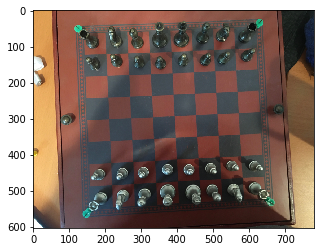

In [14]:
img_path = "../data/color-thresh-corners.JPG"

bgr_img = cv.imread(img_path)

scale_percent = 20 # percent of original size
width = int(bgr_img.shape[1] * scale_percent / 100)
height = int(bgr_img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
bgr_img = cv.resize(bgr_img, dim, interpolation = cv.INTER_AREA)

b, g, r = cv.split(bgr_img)
rgb_img = cv.merge([r, g, b])

# img = orig_img

plt.imshow(rgb_img)

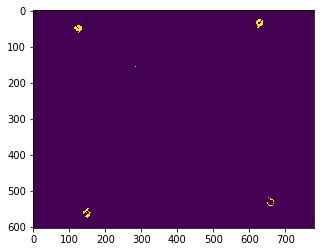

In [15]:
# plt.imshow(rgb_img[40:65,110:140])
# plt.show()

lo6 = [20, 150, 80]
lo = lo6

hi6 = [105, 245, 169]
hi = hi6

out1 = cv.inRange(rgb_img, np.array(lo), np.array(hi))
plt.imshow(out1)
plt.show()

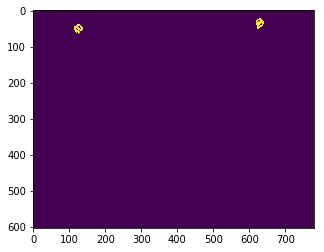

In [16]:
raw = out1.copy()
blank = np.zeros(out1.shape)
# ret, thresh = cv.threshold(gray, 127, 255, 0)
contours, hierarchy = cv.findContours(out1, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

# # draw all
# cv.drawContours(raw, contours, -1, 156, 3)

# draw max

sorted_contours = sorted(contours, key=cv.contourArea)
# c = contours[-1]
# x, y, w, h = cv.boundingRect(c)

# # draw the biggest contour (c) in green
# cv.drawContours(raw, [c], -1, 156, 3)
# print(len(contours[-4:]))
cv.drawContours(blank, contours[-8:], -1, 156, 3)
plt.imshow(blank)
plt.show()


#### Using simpleblobdetector

In [20]:
# HSV color bounds for white blobs
white_lower = np.array([0,0,160])
white_upper = np.array([255,25,255])

boardHSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
mask = cv.inRange(boardHSV, white_lower, white_upper)

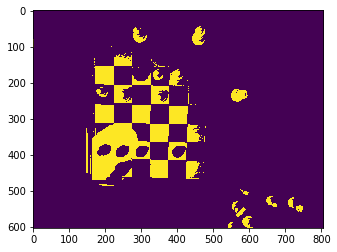

In [21]:
plt.imshow(mask)

#### Hard code image corners

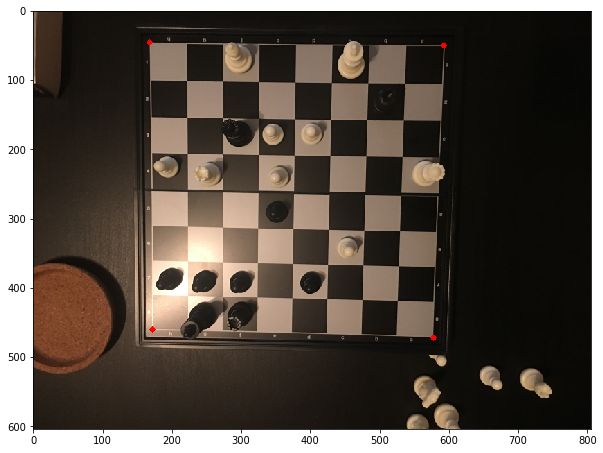

In [144]:
corners = [(168,46), (593,51), (172,460), (578,472)]
circle_img = img.copy()
for corner in corners:
    circle_img = cv.circle(circle_img, corner, 4, (255, 0, 0), -1)
plt.imshow(circle_img)

## 6. Compute transformation matrix from corners to constant image dimension (e.g. 800x800)

In [145]:
import transform

In [146]:
trans_img = transform.four_point_transform(img, transform.order_points(np.array(corners)))

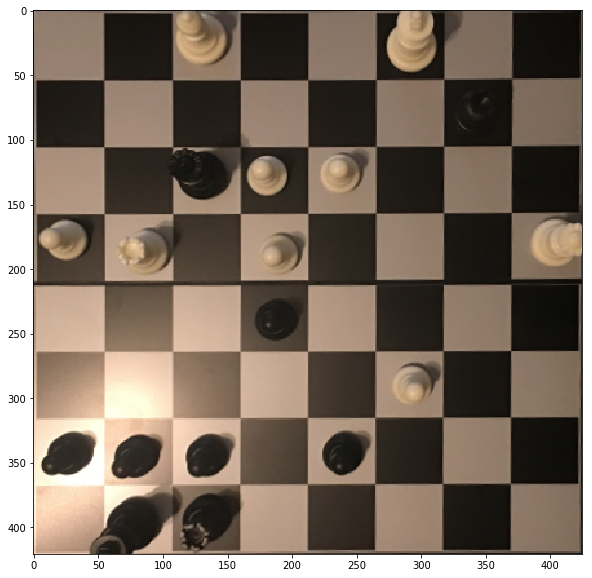

In [147]:
plt.imshow(trans_img)

## 7. Transform/crop/resize image based on transformation matrix

In [148]:
dim = (800, 800)
reduc_trans_img = cv.resize(trans_img, dim, interpolation = cv.INTER_AREA)

## 8. Segment board into 64 squares

In [149]:
squaresize = int(dim[0] / 8)
squares = [[None for _ in range(8)] for _ in range(8)]
for i in range(8):
    for j in range(8):
        squares[i][j] = reduc_trans_img[i * squaresize: (i + 1) * squaresize, j * squaresize: (j + 1) * squaresize, :]

In [150]:
square_colors = [[None for _ in range(8)] for _ in range(8)]
is_white = True
for i in range(8):
    for j in range(8):
        square_colors[i][j] = 'w' if is_white else 'b'
        is_white = not is_white
    is_white = not is_white

/Users/nashish/Library/Python/3.7/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


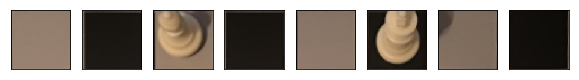

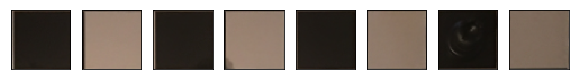

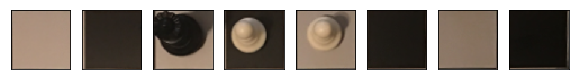

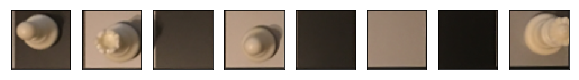

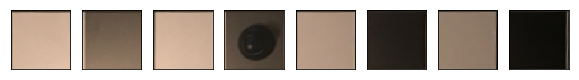

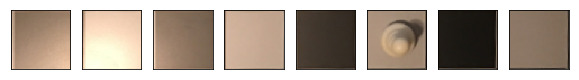

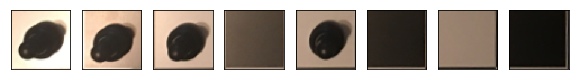

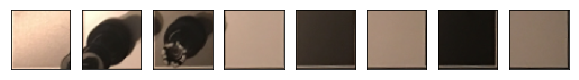

In [154]:
plt.rcParams['figure.figsize'] = [10, 10]
for i in range(8):
    plt.subplot(1,8,1)
    for j in range(8):
        ax = plt.subplot(1,8,j+1)
#         print(square_colors[i][j])
        ax.imshow(squares[i][j])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_yticks([])
    plt.show()

## 9. For each square

### a. Check if square is occupied

Test on sample occupied and sample unoccupied

#### Occupied

Text(0.5,1,'color: w')

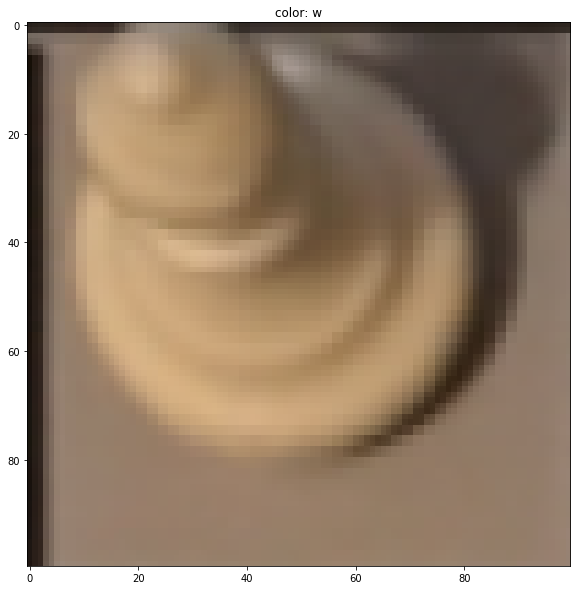

In [158]:
row_o, col_o = 0, 2
sq, color = squares[row_o][col_o], square_colors[row_o][col_o]
plt.imshow(sq)
plt.title(f"color: {color}")

[200 163 120]
<class 'numpy.uint8'>
[30 30 30]
<class 'numpy.uint8'>


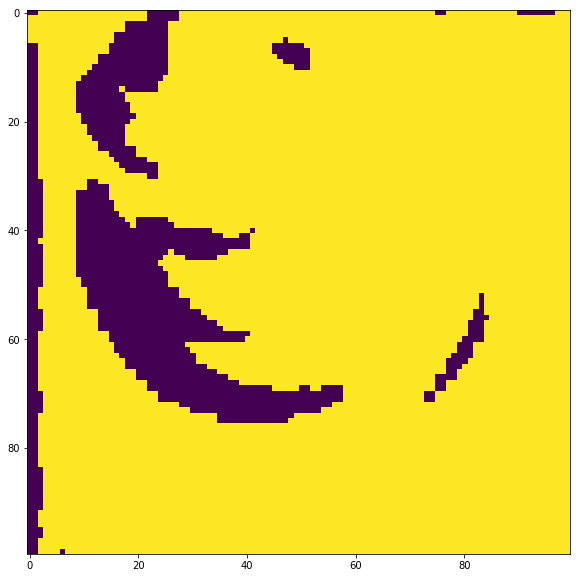

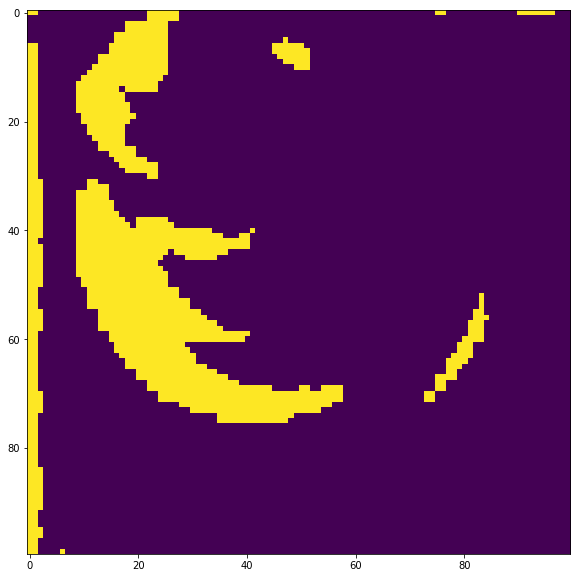

In [193]:
col = sq[60][40]
print(col)
print(type(col[0]))

lb = np.array((30, 30, 30), dtype=np.uint8)
print(lb)
print(type(lb[0]))

out1 = cv.inRange(sq, lb, col)
out2 = cv.bitwise_not(out1)
plt.imshow(out1)
plt.show()
plt.imshow(out2)
plt.show()

### b. If occupied, determine piece color

### c. Determine difference between `B[t-1]` and `B[t]` to compute `delta_matrix[i][j]`

## 10. If needed, handle piece promotion